## Setup

### Imports

In [1]:
import torch
import numpy as np
import pandas as pd
from itertools import product
from src.forward import *
from src.knn import *
from src.ftm import constants as FTM_constants
import IPython.display as ipd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

### Phi definition

In [2]:
class FIRFilter(torch.nn.Module):
    
    def __init__(self, filter_type="hp", coef=0.85, fs=44100, ntaps=101, plot=False):

        """Initilize FIR pre-emphasis filtering module."""
        super(FIRFilter, self).__init__()
        self.filter_type = filter_type
        self.coef = coef
        self.fs = fs
        self.ntaps = ntaps
        self.plot = plot

        import scipy.signal

        if ntaps % 2 == 0:
            raise ValueError(f"ntaps must be odd (ntaps={ntaps}).")

        if filter_type == "hp":
            self.fir = torch.nn.Conv1d(1, 1, kernel_size=3, bias=False, padding=1)
            self.fir.weight.requires_grad = False
            self.fir.weight.data = torch.tensor([1, -coef, 0]).view(1, 1, -1)
        elif filter_type == "fd":
            self.fir = torch.nn.Conv1d(1, 1, kernel_size=3, bias=False, padding=1)
            self.fir.weight.requires_grad = False
            self.fir.weight.data = torch.tensor([1, 0, -coef]).view(1, 1, -1)
        elif filter_type == "aw":
            # Definition of analog A-weighting filter according to IEC/CD 1672.
            f1 = 20.598997
            f2 = 107.65265
            f3 = 737.86223
            f4 = 12194.217
            A1000 = 1.9997

            NUMs = [(2 * np.pi * f4) ** 2 * (10 ** (A1000 / 20)), 0, 0, 0, 0]
            DENs = np.polymul(
                [1, 4 * np.pi * f4, (2 * np.pi * f4) ** 2],
                [1, 4 * np.pi * f1, (2 * np.pi * f1) ** 2],
            )
            DENs = np.polymul(
                np.polymul(DENs, [1, 2 * np.pi * f3]), [1, 2 * np.pi * f2]
            )

            # convert analog filter to digital filter
            b, a = scipy.signal.bilinear(NUMs, DENs, fs=fs)

            # compute the digital filter frequency response
            w_iir, h_iir = scipy.signal.freqz(b, a, worN=512, fs=fs)

            # then we fit to 101 tap FIR filter with least squares
            taps = scipy.signal.firls(ntaps, w_iir, abs(h_iir), fs=fs)

            # now implement this digital FIR filter as a Conv1d layer
            self.fir = torch.nn.Conv1d(
                1, 1, kernel_size=ntaps, bias=False, padding=ntaps // 2
            )
            self.fir.weight.requires_grad = False
            self.fir.weight.data = torch.tensor(taps.astype("float32")).view(1, 1, -1)

        self.fir.weight.data = self.fir.weight.data.to(device)

    def forward(self, input):
        """Calculate forward propagation.
        Args:
            input (Tensor): Predicted signal (B, #channels, #samples).
            target (Tensor): Groundtruth signal (B, #channels, #samples).
        Returns:
            Tensor: Filtered signal.
        """
        input = torch.nn.functional.conv1d(
            input.unsqueeze(0).to(torch.float), self.fir.weight.data, padding=self.ntaps // 2
        )
        return input.squeeze(0).to(torch.float)

### Naive k neighbours search

In [3]:
def dist_naive_tensor_wise_factory(Phi,logscale):
    return functools.partial(dist_naive_tensor_wise,Phi=Phi,logscale=logscale)

def dist_naive_tensor_wise(tensor_candidates,t_ref,Phi,logscale):
    dist_tensor = torch.zeros(tensor_candidates.size(dim=0)).to(device)
    
    #calculation of the audio for the reference node
    phi_ref = Phi(rectangular_drum(t_ref, logscale=logscale,**FTM_constants))

    for j in range(tensor_candidates.size(dim=0)):
        phi_node = Phi(rectangular_drum(tensor_candidates[j,:], logscale=logscale,**FTM_constants))
        dist_tensor[j] = torch.sum(torch.pow(torch.subtract(phi_ref, phi_node), 2), dim=0)
        
    return dist_tensor


### Approximated k neighbours search

In [4]:
# First we need to create the M matrix

# M(theta0) = grad(Phi o g)(theta0).T * grad(Phi o g)(theta0)
# This return M = f(theta0)

def M_from_G(G):
    return torch.matmul(torch.transpose(G,0,1),G)

def M_from_theta(theta, G):
    return M_from_G(G(inputs=theta))

def M_factory(logscale,Phi):
    S_from_theta = pknn_forward_factory(logscale,Phi)
    #This one is the only autograd fct we can run on our computers
    G = functools.partial(torch.autograd.functional.jacobian, func=S_from_theta, create_graph=False,strategy="forward-mode",vectorize=True) 
    M = functools.partial(M_from_theta,G=G)
    return M

# Then we define the distance function

def dist_approximated(t_candidate, t_ref, M_t_ref):
    return torch.matmul(torch.matmul(torch.transpose(M_t_ref,0,1),torch.sub(t_ref,t_candidate)),torch.sub(t_ref,t_candidate))

def dist_approximated_tensor_wise(tensor_candidates,t_ref,M): 
    dist_tensor = torch.zeros(tensor_candidates.size(dim=0)).to(device)
    M_ref = M(t_ref).to(float)
    for j in range(tensor_candidates.size(dim=0)):
        dist_tensor[j] = dist_approximated(tensor_candidates[j,:],t_ref,M_ref)
    return dist_tensor

def dist_approximated_tensor_wise_factory(Phi,logscale):
    M = M_factory(logscale,Phi)
    return functools.partial(dist_approximated_tensor_wise,M=M)


### Create Parameters Dataset

In [5]:
# Create DataFrame and write it to a CSV file for later use

def create_DF(bounds, subdiv, path):
    
    #Linspace of every parameters of size k
    Dbase = np.zeros((subdiv,5))
    for i in range(5):
        Dbase[:,i] = np.linspace(bounds[1][i][0],bounds[1][i][1],subdiv)
    baseDF = pd.DataFrame(data=Dbase,columns=bounds[0])

    #Product of the linspaces to get all the possible combinations (size subdiv**5, will take time)
    D = list(product(baseDF['omega'],baseDF['tau'],baseDF['p'],baseDF['d'],baseDF['alpha']))
    DF = pd.DataFrame(data=D,columns=bounds[0])

    DF.to_csv(path)
    
    return DF


## Main

In [ ]:
# Boundaries

bounds = [['omega', 'tau', 'p', 'd', 'alpha'],
 [(2.400247964468862, 3.798136579655672),
  (0.0700188044714488, 0.7999966616122908),
  (-4.999978530884291, -0.6989804486272966),
  (-4.99983759075039, -0.5229983775344527),
  (1.2362882382361523e-05, 0.9999649724709304)]]

# Only run this to recreate the parameters CSV, this can take a long time to finish depending on the subdivision

create_DF(bounds=bounds, subdiv=4, path='data/default_parameters.csv')


In [6]:
DatasetPath = "data/default_parameters.csv"
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True
Phi = FIRFilter()

k = 10
nref = 1

id_refs = np.linspace(0,nref-1,nref).astype(int)

#Find the knn (Approx)
print("Naive knn")

dist = dist_naive_tensor_wise_factory(Phi, logscale)
naive_id,naive_dist = find_neighbour(DatasetPath,id_refs,k,dist,return_time=True,show_progress=True)

#Find the knn (Approx)
print("Approx knn")

dist = dist_approximated_tensor_wise_factory(Phi, logscale)
approx_id,approx_dist = find_neighbour(DatasetPath,id_refs,k,dist,return_time=True,show_progress=True)


Naive knn


100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


Approx knn


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


In [11]:
print(approx_id)
print(approx_dist)

print(naive_id)
print(naive_dist)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,  16,  32,  48,  64,  80,  96, 112,  52, 116]], device='cuda:0')
tensor([ 0.0000,  0.3845,  1.5379,  3.4604, 49.1972, 52.8391, 57.2500, 62.4299,
        94.6129, 96.9195], device='cuda:0')
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 16, 32, 36, 20,  4,  8, 24, 40, 48]], device='cuda:0')
tensor([0.0000, 0.0557, 0.0673, 0.0674, 0.0674, 0.0722, 0.6054, 0.6054, 0.6074,
        1.0688], device='cuda:0')


In [15]:
#Write the neighbours of the first ref point only to a CSV file 

naive_neighbours_id = naive_id[1,0:k]
approx_neighbours_id = approx_id[1,0:k]

data = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(float)

naive_neighbours = data[naive_neighbours_id,:].cpu()
approx_neighbours = data[approx_neighbours_id,:].cpu()

print('naive:')
naive_DF = pd.DataFrame(naive_neighbours, columns=(parameters_name))
print(naive_DF)
naive_DF.to_csv("data/naive_knn.csv")

print('\napprox:')
approx_DF = pd.DataFrame(approx_neighbours, columns=(parameters_name))
print(approx_DF)
approx_DF.to_csv("data/approx_knn.csv")

naive:
      omega       tau         p         d     alpha
0  2.400248  0.070019 -4.999979 -4.999838  0.000012
1  2.400248  0.070019 -3.566313 -4.999838  0.000012
2  2.400248  0.070019 -2.132646 -4.999838  0.000012
3  2.400248  0.070019 -2.132646 -3.507558  0.000012
4  2.400248  0.070019 -3.566313 -3.507558  0.000012
5  2.400248  0.070019 -4.999979 -3.507558  0.000012
6  2.400248  0.070019 -4.999979 -2.015278  0.000012
7  2.400248  0.070019 -3.566313 -2.015278  0.000012
8  2.400248  0.070019 -2.132646 -2.015278  0.000012
9  2.400248  0.070019 -0.698980 -4.999838  0.000012

approx:
      omega       tau         p         d     alpha
0  2.400248  0.070019 -4.999979 -4.999838  0.000012
1  2.400248  0.070019 -3.566313 -4.999838  0.000012
2  2.400248  0.070019 -2.132646 -4.999838  0.000012
3  2.400248  0.070019 -0.698980 -4.999838  0.000012
4  2.400248  0.313345 -4.999979 -4.999838  0.000012
5  2.400248  0.313345 -3.566313 -4.999838  0.000012
6  2.400248  0.313345 -2.132646 -4.999838  0.000

# Method characterization

In [16]:
#Defined the list of parameters
approx_neighbours = []
naive_neighbours = []

parameters_name = ['omega', 'tau', 'p', 'd', 'alpha']

#Recover all parameters
data = pd.read_csv("data/naive_knn.csv", index_col=0)
data_size = data.size
for i in range(int(data_size/5)):
    #Get phi of the neighbour
    parameterLine = data.iloc[[i]]
    theta = np.array([ parameterLine[parameters_name[k]].iloc[0] for k in range(len(parameters_name)) ])
    naive_neighbours.append(theta)

#Recover all parameters
data1 = pd.read_csv("data/approx_knn.csv", index_col=0)
data_size = data.size
for i in range(int(data_size/5)):
    #Get phi of the neighbour
    parameterLine = data1.iloc[[i]]
    theta = np.array([ parameterLine[parameters_name[k]].iloc[0] for k in range(len(parameters_name)) ])
    approx_neighbours.append(theta)

In [17]:
dist = dist_naive_tensor_wise_factory(Phi, logscale)

print(dist(torch.tensor(naive_neighbours),naive_neighbours[0]))
print("aaaa")
print(dist(torch.tensor(approx_neighbours),approx_neighbours[0]))

tensor([1.1005e-12, 5.5747e-02, 6.7323e-02, 6.7357e-02, 6.7424e-02, 7.2159e-02,
        6.0542e-01, 6.0542e-01, 6.0737e-01, 1.0688e+00], device='cuda:0')
aaaa
tensor([1.1005e-12, 5.5747e-02, 6.7323e-02, 1.0688e+00, 1.6567e+01, 1.9962e+01,
        1.9047e+01, 1.9055e+01, 1.0702e+00, 1.9055e+01], device='cuda:0')


In [ ]:
#LISTEN HERE the truth

#Calulate audios from the parameters
for i in range(len(naive_neighbours)):
    print("Neighbours n°",i+1)
    audio = rectangular_drum(naive_neighbours[i],logscale=True,**FTM_constants)
    ipd.display(ipd.Audio(data=audio.cpu().detach(), rate=44100))

In [ ]:
#LISTEN HERE the approximation

#Calulate audios from the parameters
for i in range(len(approx_neighbours)):
    print("Neighbours n°",i+1)
    audio = rectangular_drum(approx_neighbours[i], True,**FTM_constants)
    ipd.display(ipd.Audio(data=audio.cpu().detach(), rate=44100))


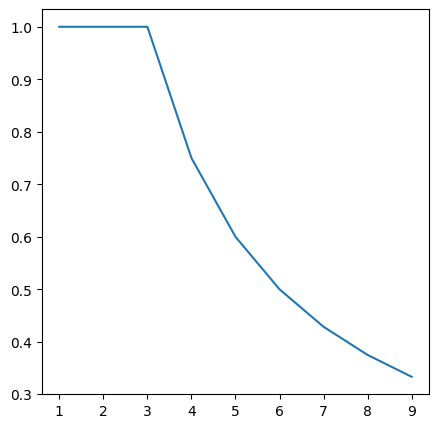

In [18]:
# How many neighbours to use 

precision = []

for n in range(1,len(naive_neighbours)):

    naive_neighbours_to_use = naive_neighbours[:n]
    approx_neighbours_to_use = approx_neighbours[:n]

    #Precision and recall

    t_p = 0
    f_p = 0

    def inList(element,list_l):
        for i in range(len(list_l)):
            equal = True
            for k in range(len(list_l[i])):
                if(list_l[i][k]!= element[k]):
                    equal = False
            if (equal):
                return True

    for i in range(len(naive_neighbours_to_use)):
        if (inList(approx_neighbours_to_use[i],naive_neighbours_to_use)):
            t_p += 1
        else:
            f_p += 1

    #print("Precision : ",t_p/len(naive_neighbours_to_use))
    #print("Recall : ",f_p/len(naive_neighbours_to_use))

    precision.append(t_p/len(naive_neighbours_to_use))

x = np.linspace(1,len(naive_neighbours)-1,len(naive_neighbours)-1)

plt.figure(figsize=(5,5))
plt.plot(x,precision)
plt.show()